In [19]:
# Test migration history reconstruction on simulated data

import sys
import os

repo_dir = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/"
os.chdir(repo_dir)
from src.lib import vertex_labeling

from src.util import machina_data_extraction_util as mach_util
from src.util import vertex_labeling_util as vert_util
import matplotlib
import torch

MACHINA_DATA_DIR = os.path.join(repo_dir, 'src/data/machina_sims')


CUDA GPU: False
CUDA GPU: False
CUDA GPU: False


In [20]:
custom_colors = [matplotlib.colors.to_hex(c) for c in ['limegreen', 'cornflowerblue', 'hotpink', 'grey', 'saddlebrown', 'darkorange', 'purple', 'red', 'black', 'black', 'black', 'black']]
custom_colors = ["#6aa84fff","#c27ba0ff", "#be5742e1", "#6fa8dcff", "#e69138ff", "#9e9e9eff"]
def find_labelings_all_mutation_trees(cluster_fn, all_mut_trees_fn, ref_var_fn, use_gen_dist=False):
    cluster_label_to_idx = mach_util.get_cluster_label_to_idx(cluster_fn, ignore_polytomies=True)
    data = mach_util.get_adj_matrices_from_all_mutation_trees(all_mut_trees_fn, cluster_label_to_idx, is_sim_data=True)
    print("num trees:", len(data))
    i = 1
    for adj_matrix, pruned_cluster_label_to_idx in data:
        print(f"TREE {i}")
        T = torch.tensor(adj_matrix, dtype = torch.float32)
        B = vert_util.get_mutation_matrix_tensor(T)
        ref_matrix, var_matrix, unique_sites= mach_util.get_ref_var_matrices_from_machina_sim_data(ref_var_fn, 
                                                                                                   pruned_cluster_label_to_idx=pruned_cluster_label_to_idx,
                                                                                                   T=T)
        G = mach_util.get_genetic_distance_tensor_from_sim_adj_matrix(T, pruned_cluster_label_to_idx)
        G = G if use_gen_dist else None
        print("G\n", G)
        idx_to_label = {v:k for k,v in pruned_cluster_label_to_idx.items()}
        print(idx_to_label)
        print(unique_sites)   
        primary_idx = unique_sites.index('P')
        r = torch.nn.functional.one_hot(torch.tensor([primary_idx]), num_classes=len(unique_sites)).T
        weights = vertex_labeling.Weights(data_fit=1.0, mig=10.0, comig=5.0, seed_site=1.0, reg=1.0, gen_dist=0.5)
        vertex_labeling.gumbel_softmax_optimization(T, ref_matrix, var_matrix, B, ordered_sites=unique_sites, 
                                                    weights=weights, p=r, node_idx_to_label=idx_to_label, G=G,
                                                    batch_size=16, init_temp=30, final_temp=0.01, 
                                                    custom_colors=custom_colors, show_top_trees=False, verbose=True)
        print("*"*100)
        i += 1

import pydot
from IPython.display import Image, display

def visualize_ground_truth(tree_fn, graph_fn):
    def view_pydot(pdot):
        plt = Image(pdot.create_png())
        display(plt)
    
    (graph,) = pydot.graph_from_dot_file(tree_fn)
    view_pydot(graph)

    (graph,) = pydot.graph_from_dot_file(graph_fn)
    view_pydot(graph)
        
        

Ground truth


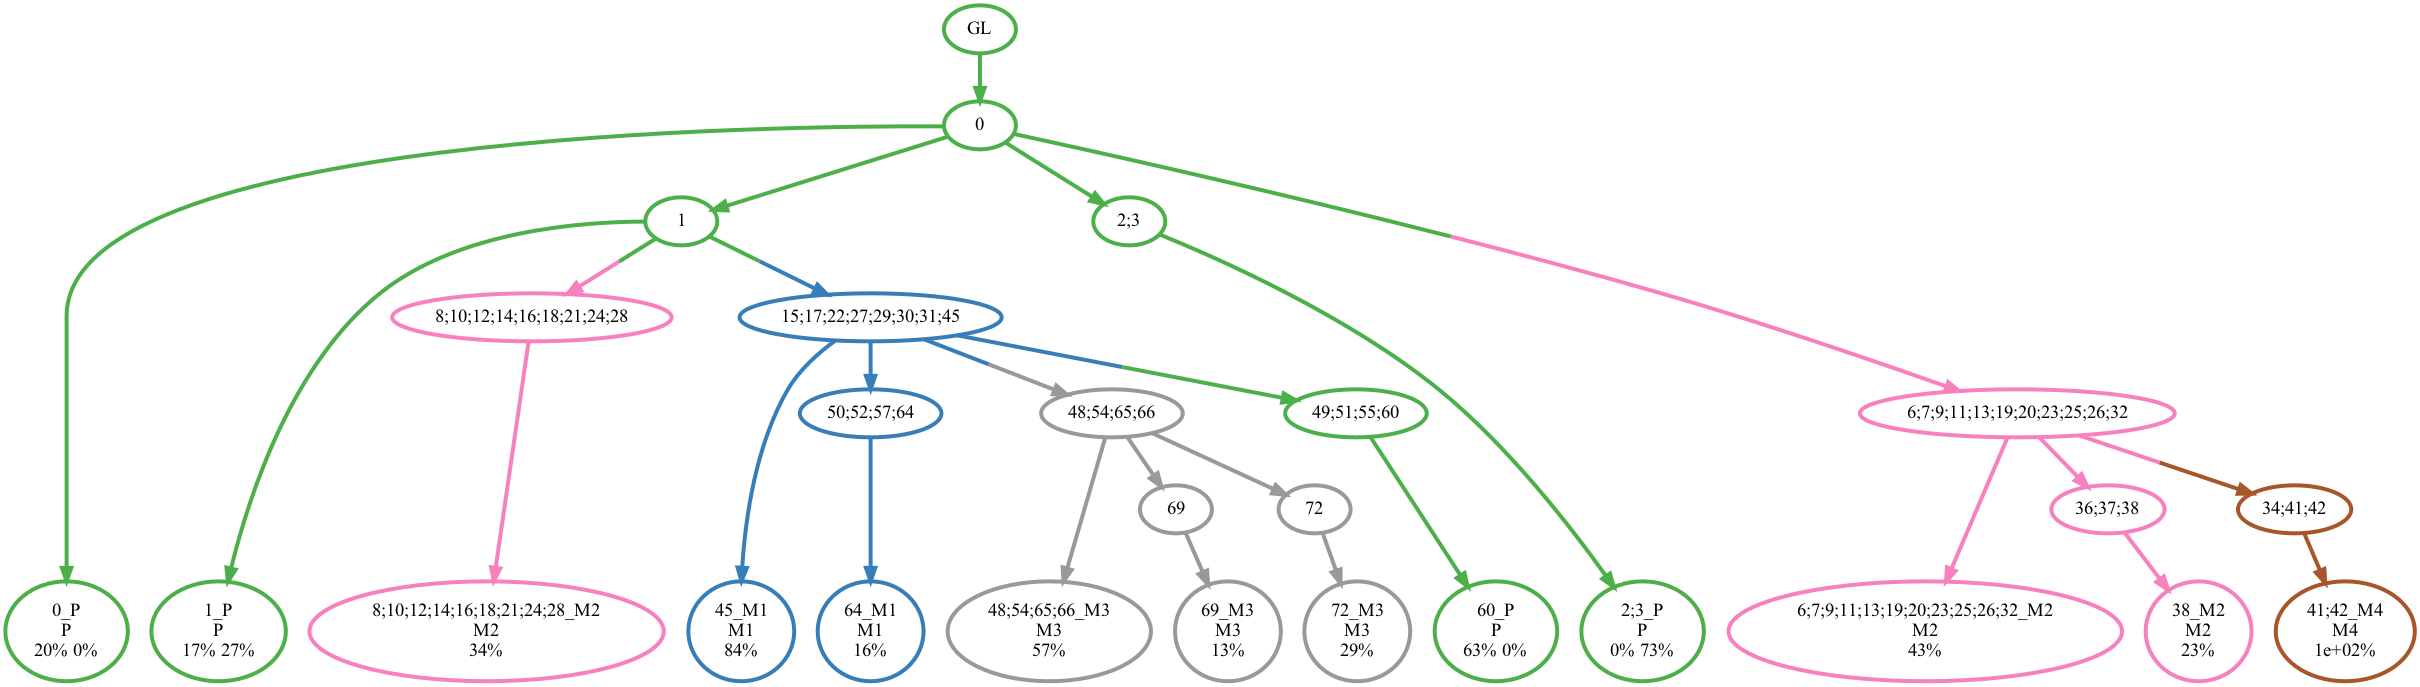

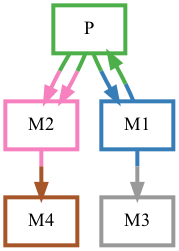

In [23]:
num_sites = "m5"
mig_type = "R"
SEED = 518
SIM_DATA_DIR = os.path.join(MACHINA_DATA_DIR, num_sites, mig_type)

print("Ground truth")
visualize_ground_truth(os.path.join(SIM_DATA_DIR, f"T_seed{SEED}.dot"), os.path.join(SIM_DATA_DIR, f"G_seed{SEED}.dot"))


num trees: 2
TREE 1
G
 None
{0: '0', 1: '1', 2: '2;3', 3: '6;7;9;11;13;19;20;23;25;26;32', 4: '8;10;12;14;16;18;21;24;28;36;37;38', 5: '34;41;42', 6: '15;17;22;27;29;30;31;45', 7: '49;51;55;60', 8: '50;52;57;64', 9: '48;54;65;66', 10: '69;72'}
['P', 'M1', 'M2', 'M3', 'M4']


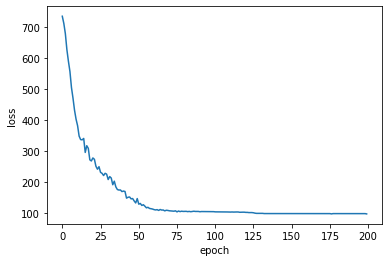

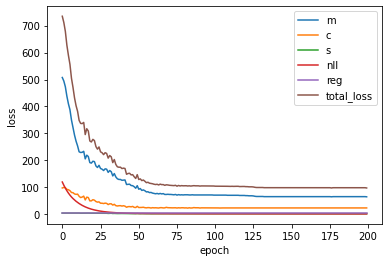

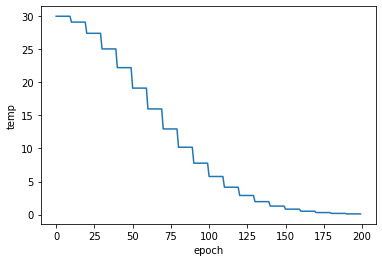

12:42:27 DEBUG

U > 0.05

12:42:27 DEBUG
    norm     0     1   2;3   6;7  8;10  34;41  15;17  49;51  50;52  48;54  \
P  0.058 0.000 0.322 0.000 0.000 0.000  0.000  0.000  0.598  0.000  0.000   
M1 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.814  0.000  0.163  0.000   
M2 0.073 0.000 0.243 0.000 0.368 0.296  0.000  0.000  0.000  0.000  0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000  0.000  0.000  0.754   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.969  0.000  0.000  0.000  0.000   

    69;72  
P   0.000  
M1  0.000  
M2  0.000  
M3  0.228  
M4  0.000  
12:42:27 DEBUG

F_hat
12:42:27 DEBUG
tensor([[0.9785, 0.9204, 0.9204, 0.0000, 0.0000, 0.0000, 0.0000, 0.5980, 0.5980,
         0.0000, 0.0000, 0.0000],
        [0.9771, 0.9771, 0.9771, 0.0000, 0.0000, 0.0000, 0.0000, 0.9771, 0.0000,
         0.1633, 0.0000, 0.0000],
        [0.9805, 0.9077, 0.2435, 0.0000, 0.6642, 0.2958, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.9824, 0.9824, 0.9824, 0.0000, 0

****************************** BEST TREE ******************************

Migration number: 6.0
Comigration number: 4.0
Seeding site number: 2.0
Neg log likelihood: 1.548
Reg: 5.0
Loss: 88.548


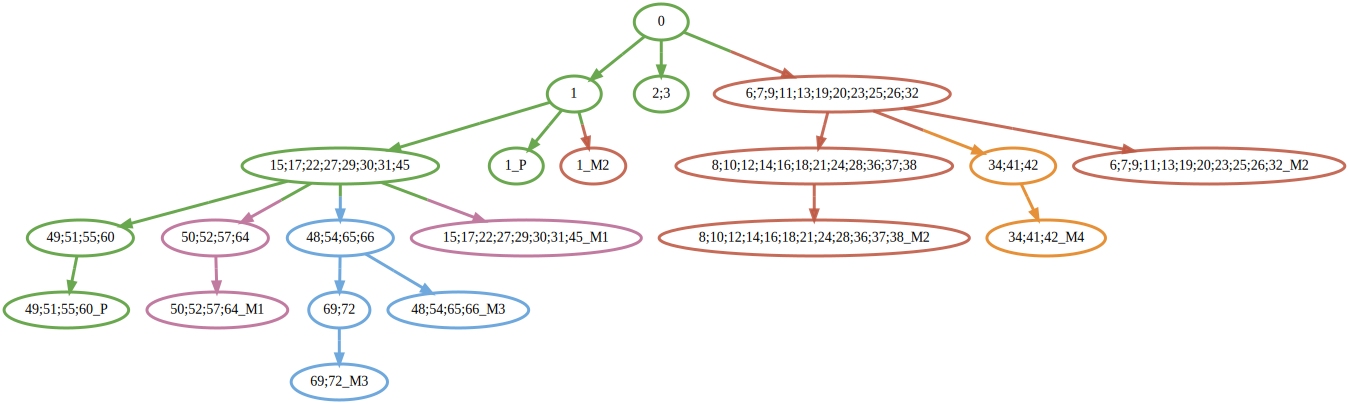

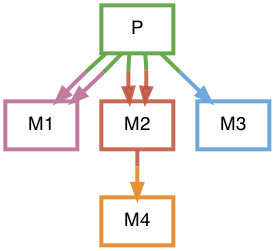

Time elapsed: 5.361356
****************************************************************************************************
TREE 2
G
 None
{0: '0', 1: '1', 2: '2;3', 3: '6;7;9;11;13;19;20;23;25;26;32', 4: '8;10;12;14;16;18;21;24;28;36;37;38', 5: '34;41;42', 6: '15;17;22;27;29;30;31;45', 7: '49;51;55;60', 8: '50;52;57;64', 9: '48;54;65;66', 10: '69;72'}
['P', 'M1', 'M2', 'M3', 'M4']


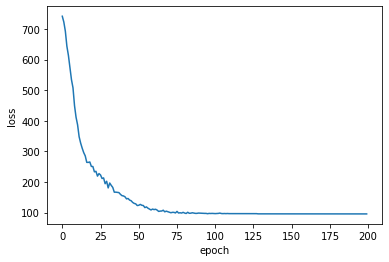

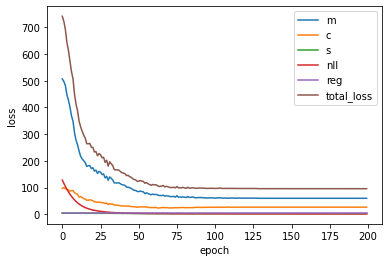

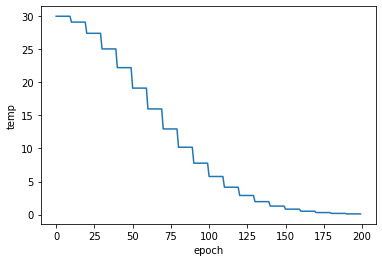

12:42:33 DEBUG

U > 0.05

12:42:33 DEBUG
    norm     0     1   2;3   6;7  8;10  34;41  15;17  49;51  50;52  48;54  \
P  0.061 0.000 0.323 0.000 0.000 0.000  0.000  0.000  0.600  0.000  0.000   
M1 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.821  0.000  0.163  0.000   
M2 0.000 0.000 0.000 0.000 0.655 0.289  0.000  0.000  0.000  0.000  0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000  0.000  0.000  0.756   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.960  0.000  0.000  0.000  0.000   

    69;72  
P   0.000  
M1  0.000  
M2  0.000  
M3  0.227  
M4  0.000  
12:42:33 DEBUG

F_hat
12:42:33 DEBUG
tensor([[0.9833, 0.9227, 0.9227, 0.0000, 0.0000, 0.0000, 0.0000, 0.5998, 0.5998,
         0.0000, 0.0000, 0.0000],
        [0.9834, 0.9834, 0.9834, 0.0000, 0.0000, 0.0000, 0.0000, 0.9834, 0.0000,
         0.1628, 0.0000, 0.0000],
        [0.9435, 0.9435, 0.2890, 0.0000, 0.6545, 0.2890, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.9833, 0.9833, 0.9833, 0.0000, 0

****************************** BEST TREE ******************************

Migration number: 6.0
Comigration number: 4.0
Seeding site number: 2.0
Neg log likelihood: 1.567
Reg: 5.0
Loss: 88.567


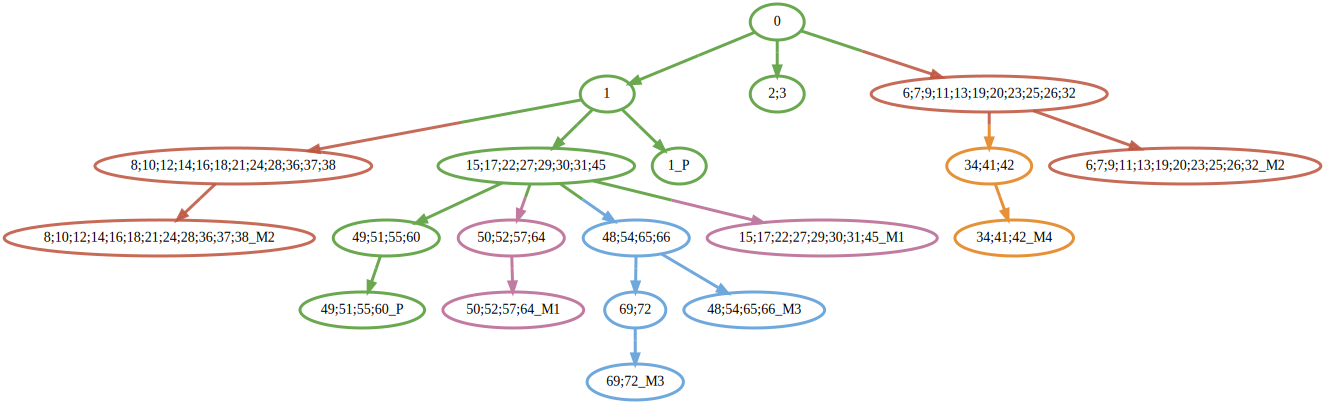

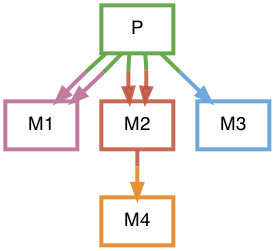

Time elapsed: 5.358579
****************************************************************************************************
CPU times: user 16.5 s, sys: 12.7 s, total: 29.2 s
Wall time: 10.8 s


In [27]:
%%time

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.tsv"),
                                  use_gen_dist=False)




num trees: 2
TREE 1
G
 tensor([[ 0.,  1.,  2., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 12.,  3.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  4.,  4.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
{0: '0', 1: '1', 2: '2;3', 3: '6;7;9;11;13;19;20;23;25;26;32', 4: '8;10;12;14;16;18;21;24;28;36;37;38', 5: '34;41;42', 6: '15;17;22;27;29;30;31;45', 7: '49;51;55;60', 8: '50;52;57;64', 9: '48;54;65;66', 10: '69;72'}
['P', 'M1', 'M2', 'M3', 'M4']


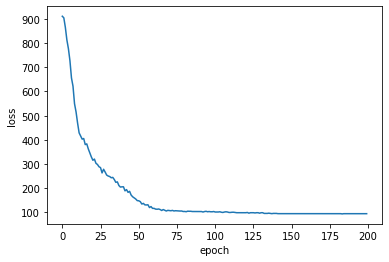

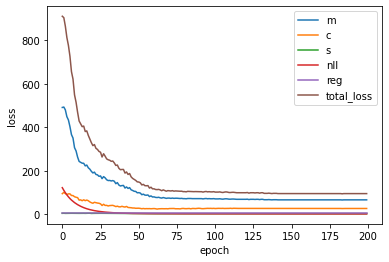

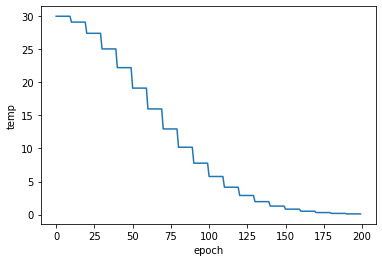

12:41:52 DEBUG

U > 0.05

12:41:52 DEBUG
    norm     0     1   2;3   6;7  8;10  34;41  15;17  49;51  50;52  48;54  \
P  0.059 0.000 0.322 0.000 0.000 0.000  0.000  0.000  0.599  0.000  0.000   
M1 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.814  0.000  0.163  0.000   
M2 0.078 0.000 0.241 0.000 0.368 0.296  0.000  0.000  0.000  0.000  0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000  0.000  0.000  0.754   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.966  0.000  0.000  0.000  0.000   

    69;72  
P   0.000  
M1  0.000  
M2  0.000  
M3  0.226  
M4  0.000  
12:41:52 DEBUG

F_hat
12:41:52 DEBUG
tensor([[0.9801, 0.9212, 0.9212, 0.0000, 0.0000, 0.0000, 0.0000, 0.5993, 0.5993,
         0.0000, 0.0000, 0.0000],
        [0.9765, 0.9765, 0.9765, 0.0000, 0.0000, 0.0000, 0.0000, 0.9765, 0.0000,
         0.1630, 0.0000, 0.0000],
        [0.9838, 0.9059, 0.2414, 0.0000, 0.6646, 0.2961, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.9802, 0.9802, 0.9802, 0.0000, 0

****************************** BEST TREE ******************************

Migration number: 6.0
Comigration number: 5.0
Seeding site number: 3.0
Neg log likelihood: 1.54
Reg: 5.0
Genetic distance: -20.0
Loss: 84.54


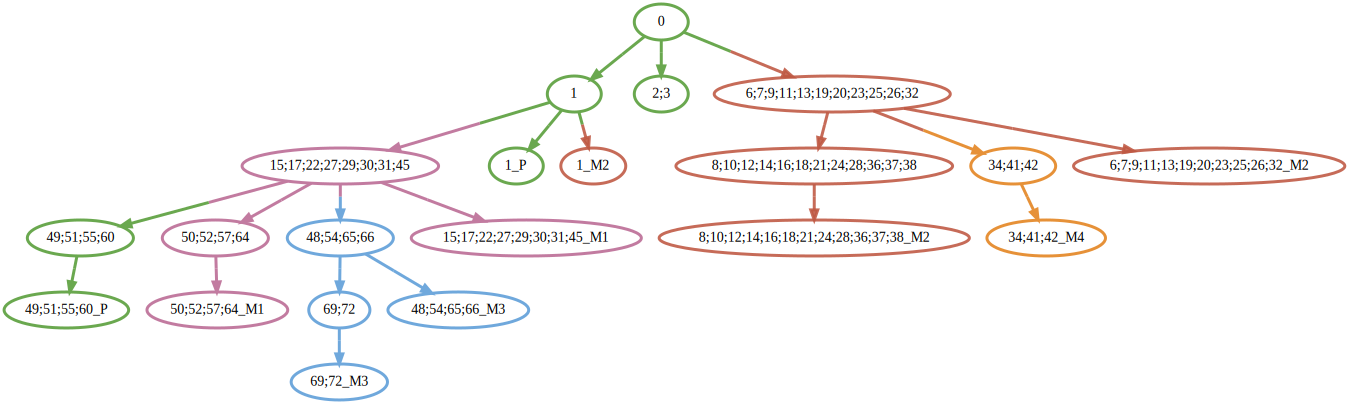

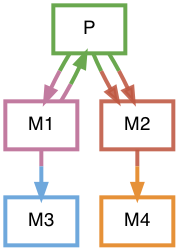

Time elapsed: 6.177127
****************************************************************************************************
TREE 2
G
 tensor([[ 0.,  1.,  2., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 12.,  0.,  8.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  4.,  4.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
{0: '0', 1: '1', 2: '2;3', 3: '6;7;9;11;13;19;20;23;25;26;32', 4: '8;10;12;14;16;18;21;24;28;36;37;38', 5: '34;41;42', 6: '15;17;22;27;29;30;31;45', 7

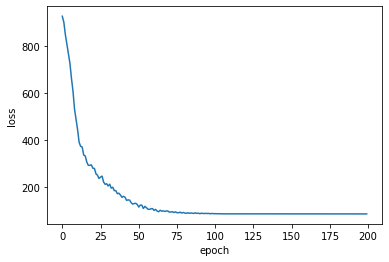

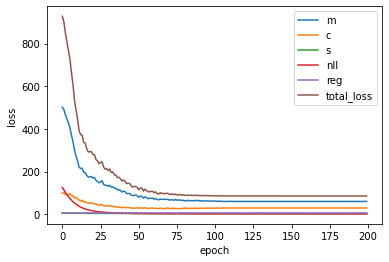

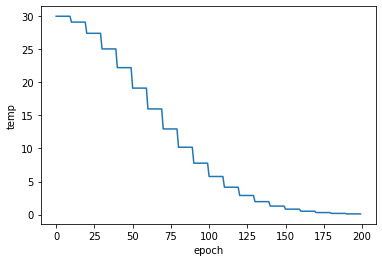

12:41:58 DEBUG

U > 0.05

12:41:58 DEBUG
    norm     0     1   2;3   6;7  8;10  34;41  15;17  49;51  50;52  48;54  \
P  0.062 0.000 0.324 0.000 0.000 0.000  0.000  0.000  0.601  0.000  0.000   
M1 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.820  0.000  0.163  0.000   
M2 0.000 0.000 0.000 0.000 0.659 0.290  0.000  0.000  0.000  0.000  0.000   
M3 0.000 0.000 0.000 0.000 0.000 0.000  0.000  0.000  0.000  0.000  0.756   
M4 0.000 0.000 0.000 0.000 0.000 0.000  0.952  0.000  0.000  0.000  0.000   

    69;72  
P   0.000  
M1  0.000  
M2  0.000  
M3  0.227  
M4  0.000  
12:41:58 DEBUG

F_hat
12:41:58 DEBUG
tensor([[0.9861, 0.9243, 0.9243, 0.0000, 0.0000, 0.0000, 0.0000, 0.6005, 0.6005,
         0.0000, 0.0000, 0.0000],
        [0.9833, 0.9833, 0.9833, 0.0000, 0.0000, 0.0000, 0.0000, 0.9833, 0.0000,
         0.1632, 0.0000, 0.0000],
        [0.9491, 0.9491, 0.2900, 0.0000, 0.6591, 0.2900, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.9835, 0.9835, 0.9835, 0.0000, 0

****************************** BEST TREE ******************************

Migration number: 6.0
Comigration number: 6.0
Seeding site number: 3.0
Neg log likelihood: 1.561
Reg: 5.0
Genetic distance: -29.0
Loss: 85.061


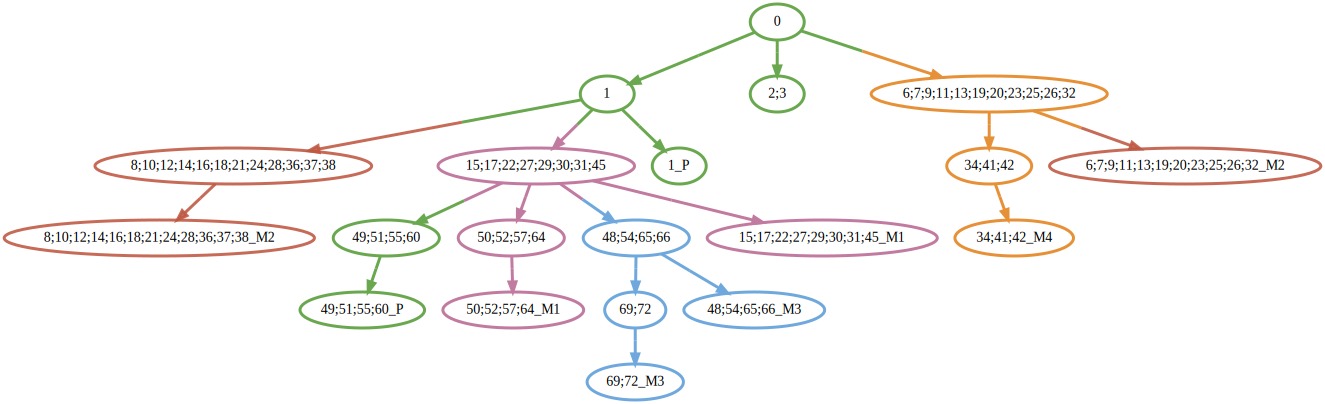

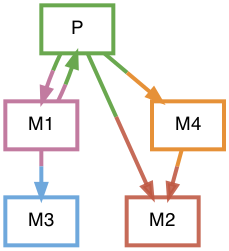

Time elapsed: 5.962978
****************************************************************************************************
CPU times: user 18.5 s, sys: 13.3 s, total: 31.9 s
Wall time: 12.2 s


In [26]:
%%time

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.tsv"),
                                  use_gen_dist=True)




In [6]:
p = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/src/test/machina_simulated_data/predictions_wm3_wc2_wg0.5_bs32_11032022"
p = os.path.join(p, num_sites, mig_type)
visualize_ground_truth(os.path.join(p, f"T_tree0_seed{SEED}.predicted.tree"), os.path.join(p, f"G_tree0_seed{SEED}.predicted.tree"))


0 8;15;22
^
Expected {'graph' | 'digraph'}, found '0'  (at char 0), (line:1, col:1)


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
import fnmatch
import matplotlib.pyplot as plt
def count_trees(sims_data_dir):
    sites = ["m8", "m5"]
    mig_types = ["M", "mS", "R", "S"]
    tree_cts = []
    ct = 0
    seed_ct = 0
    for site in sites:
        for mig_type in mig_types:
            local_ct = 0
            site_mig_data_dir = os.path.join(sims_data_dir, site, mig_type)
            seeds = fnmatch.filter(os.listdir(site_mig_data_dir), 'reads_seed*.tsv')
            seeds = [s.replace(".tsv", "").replace("reads_seed", "") for s in seeds]
            for seed in seeds:
                all_mut_trees_fn = os.path.join(sims_data_dir, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt")
                with open(all_mut_trees_fn, 'r') as f:
                    for line in f:
                        if "#trees" in line:
                            tree_ct = int(line.split()[0])
                            tree_cts.append(tree_ct)
                            if tree_ct > 50:
                                print("tree > 50 trees", site, mig_type, seed, tree_ct)
                            ct += tree_ct
                            local_ct += tree_ct
                            break
                seed_ct += 1
            print(site, mig_type, local_ct)
    print(tree_cts)
    plt.hist(tree_cts)
    plt.show()
    plt.close()
    print("Number of total trees:", ct)

count_trees(MACHINA_DATA_DIR)
count_trees(RERUN_SIM_DIR)

In [ ]:
fn = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/results_8cores_time_test.txt"
fn2 = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/results_8cores_time_test2.txt"
from datetime import datetime

output = []
with open(fn) as f:
    for i,line in enumerate(f):
        items = line.strip().split(',')
        if i != 0:
            epoch_time = datetime(1900, 1, 1)
            
            secs = (datetime.strptime(items[4][items[4].find('days')+5:], "%H:%M:%S.%f") - epoch_time).total_seconds()
            #print(secs)
            items[4] = secs
            #print(items)
            output.append(items)
        else:
            output.append(items)

print(output)
import csv
with open(fn2, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter=',', lineterminator='\n')
    for line in output:
        writer.writerow(line)

In [ ]:
mig_type = "S"
SEED = 23

RERUN_SIM_DIR = os.path.join(repo_dir, 'src/data/rerun_machina_sims')
RERUN_SIM_DATA_DIR = os.path.join(RERUN_SIM_DIR, num_sites, mig_type)

print("Manually generated sims")
visualize_ground_truth(os.path.join(RERUN_SIM_DATA_DIR, f"T_seed{SEED}.dot"), os.path.join(RERUN_SIM_DATA_DIR, f"G_seed{SEED}.dot"))
